#Implementation for Point 1
------

##Definition for Point 1 </br>
Use this dataset (https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to train a CNN. Use no other data source or pretrained networks, and explain your design choices during preprocessing, model building and training. Also, cite the sources you used to borrow techniques. A test set will be provided later to judge the performance of your classifier. Please save your model checkpoints.

##Solution
The explanation for the design choices will be given in the following sections.

###Model Architecture

<font size=3px>
1. Conv(1, 32) -> ReLU -> Dropout -> Maxpool</br>
2. Conv(32, 64) -> ReLU -> Dropout -> Maxpool</br>
3. Conv(64, 128) -> ReLU -> Dropout -> Maxpool</br>
4. Conv(128, 256) -> ReLU -> Dropout -> Maxpool</br>
5. Conv(256, 512) -> ReLU -> Dropout -> Maxpool</br>
6. Transformer Encoder Layer</br>
7. Transformer Encoder Layer</br>
8. Transformer Encoder Layer</br>
9. Fully Connected Layer (512, 62)</br>
</font>

<font color='blue'>Optimizer</font>: Adam (lr: 0.0001)</br>
<font color='blue'>Loss</font>: CrossEntropyLoss</br>


**Conclusions**</br>
At epoch 29:</br>
Without Augmentation:</br>
Training Accuracy: 97.53%	
Validation Accuracy: 72.90%</br>

With Augmentation:</br>
Training Accuracy: 93.99% 	
Validation Accuracy: 77.90%

If the notebook is being run on the local system, please download the necessary files from the drive link provided in the code cells.</br>
<font color="blue">*Please change the links accordingly*</font>

<font color='grey'>*The following code is implemented in PyTorch.*</font>




#Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pycm

In [ ]:
# Point 1's data is accessed via the zip file stored in the drive
# This zip file is transferred to the disk of the google colab, 
# because accessing it from the disk directly is faster than
# accessing the images from the drive

# Link to the zip file: https://drive.google.com/file/d/1g4dHphWLCX1PisdXacrfw8kdn7MGoxv5/view?usp=sharing
!cp -r "/content/drive/MyDrive/MIDAS/Point1/train.zip" "/content/train.zip" 
!unzip train.zip

In [ ]:
import numpy as np
import torch
import csv
from torch import nn
import pandas as pd
import cv2 as cv
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ZeroPad2d
from torchvision import transforms
import shutil
from sklearn.metrics import auc, confusion_matrix, classification_report
import seaborn as sns
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import random
from pycm import *

#Data Preparation

Following factors have been taken care of in this stage:


*   Image is resized to 200 * 200
*   Augmentation may or may not be performed on the training data
*   All images have been normalised

The only augmentation that is performed is Rotation.
The explanation for this is that the performance degraded on trying other augmentations like translation and shearing.




In [ ]:
#All images are resized to 200 * 200 and have been normalized
def _preprocess(image):
    # Preprocessing step
    img_transform = transforms.Compose([
        transforms.ToPILImage(),              #Conversion to PIL Image
        transforms.Resize((200, 200)),        #Resize image to 200 * 200
        transforms.ToTensor(),                #Conversion to Tensor
        transforms.Normalize((0.5, ), (0.5,)) #Normalise Image
    ])
    return img_transform(image)

#Used for augmenting training data
def _preprocess_aug(image):
  transform_aug = transforms.Compose([
     transforms.ToPILImage(),                 #Conversion to PIL Image                                      
     transforms.Resize((200, 200)),           #Resize image to 200 * 200                                                     
     transforms.RandomRotation(20),           #Apply rotations upto 20 degrees     
     #transforms.RandomAffine(0),
     transforms.ToTensor(),                   #Conversion to Tensor
     transforms.Normalize((0.5, ), (0.5,))    #Normalise Image
    ])

  return transform_aug(image)

Use the below class for augmentation

In [ ]:
#Class used by DataLoader for training data
class Images_train(Dataset):
  def __init__(self, df):
        #DataFrame Structure must be of the form: | FilePath | Label |
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE) #Column 0: FilePath
    temp=random.randint(0,1)            #The temp variable takes care of the fact that not all images are augmented.
    if temp == 1:                       #If temp is 1, 
      image1 = _preprocess_aug(image1)  #augment the image
    else:                               #else
      image1 = _preprocess(image1)      #No augmentations are to be performed

    label = self.data.iloc[index, 1] #Column 1: Label

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

Use the below class if augmentation is not required

In [ ]:
#Class used by DataLoader for training data
class Images_train(Dataset):
  def __init__(self, df):
        #DataFrame Structure must be of the form: | FilePath | Label |
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE) #Column 0: FilePath
    image1 = _preprocess(image1)

    label = self.data.iloc[index, 1] #Column 1: Label

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
#Class used by DataLoader for testing data
class Images_test(Dataset):
  def __init__(self, df):
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE) #Column 0: FilePath
    image1 = _preprocess(image1)

    label = self.data.iloc[index, 1] #Column 1: Label

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MIDAS/Point1/pointOne_cpath.csv")
df = df.sample(frac = 1)
df.head()

,FilePath,Label
522,/content/train/Sample035/img035-022.png,34
318,/content/train/Sample034/img034-011.png,33
2310,/content/train/Sample040/img040-037.png,39
2462,/content/train/Sample012/img012-046.png,11
856,/content/train/Sample018/img018-030.png,17


In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.25) #Split of 75/25
train_dataset = Images_train(df_train)
valid_dataset = Images_test(df_valid)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  #Train
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)  #Test

train_iter = iter(train_loader) 
images1, labels = train_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

val_iter = iter(val_loader)
images1, labels = val_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 1, 200, 200])
labels shape on batch size = torch.Size([8, 1])
images shape on batch size = torch.Size([1, 1, 200, 200])
labels shape on batch size = torch.Size([1, 1])


#Model Creation

The following is the description of the model architecture:
<font size=3px>
1. Conv(1, 32) -> ReLU -> Dropout -> Maxpool</br>
2. Conv(32, 64) -> ReLU -> Dropout -> Maxpool</br>
3. Conv(64, 128) -> ReLU -> Dropout -> Maxpool</br>
4. Conv(128, 256) -> ReLU -> Dropout -> Maxpool</br>
5. Conv(256, 512) -> ReLU -> Dropout -> Maxpool</br>
6. Transformer Encoder Layer</br>
7. Transformer Encoder Layer</br>
8. Transformer Encoder Layer</br>
9. Fully Connected Layer (512, 62)</br>
</font>

##Explanation:
The idea is to chain a convolutional neural network (CNN), with a Transformer encoder architecture. This CNN is responsible for extraction of the local information from the image and the Transformer encoder, reasons about the image as a whole and then generates the predictions. 

The transformer encoder is used to improve the embeddings recieved from the CNN, and the reason why it should succeed is because of the concept of "Attention" that is used in them. 




In [ ]:
class smallModel(nn.Module):
  def __init__(self):
    super(smallModel, self).__init__()
    
    self.zp1 = nn.ZeroPad2d(1)
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.mp1 = nn.MaxPool2d(kernel_size=2)
    self.dp = nn.Dropout(p=0.3)

    self.zp2 = nn.ZeroPad2d(1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.mp2 = nn.MaxPool2d(kernel_size=2)

    self.zp3 = nn.ZeroPad2d(1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.mp3 = nn.MaxPool2d(kernel_size=2)

    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.mp4 = nn.MaxPool2d(kernel_size=2)

    self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.mp5 = nn.MaxPool2d(kernel_size=2)

    self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3) #num_layers=3: Three encoder layers in one block

    self.relu = nn.ReLU()

    self.row_emb = nn.Parameter(torch.rand(64, 512 // 2)) #[64, 256]
    self.col_emb = nn.Parameter(torch.rand(64, 512 // 2)) #[64, 256]

    self.fc4 = nn.Linear(512 * 6 * 6, 62)

    #Kindly ignore these layers
    self.fc1 = nn.Linear(512 * 6 * 6, 9216)
    self.fc2 = nn.Linear(9216, 4096)
    self.fc3 = nn.Linear(4096, 1024)


  def forward(self, x):
    x = self.dp(self.relu(self.conv1(x)))   #Conv -> ReLU -> Dropout: 200 * 200 * 32
    x = self.mp1(x)                         #MaxPool: 100 * 100 * 32

    x = self.dp(self.relu(self.conv2(x)))   #Conv -> ReLU -> Dropout: 100 * 100 * 64
    x = self.mp2(x)                         #MaxPool: 50 * 50 * 64

    x = self.dp(self.relu(self.conv3(x)))   #Conv -> ReLU -> Dropout: 50 * 50 * 128
    x = self.mp3(x)                         #MaxPool: 25 * 25 * 128

    x = self.dp(self.relu(self.conv4(x)))   #Conv -> ReLU -> Dropout: 25 * 25 * 256
    x = self.mp4(x)                         #MaxPool: 12 * 12 * 256

    x = self.dp(self.relu(self.conv5(x)))   #Conv -> ReLU -> Dropout: 12 * 12 * 512
    x = self.mp5(x)                         #MaxPool: 6 * 6 * 512

    H = x.shape[-1]#H = 6
    W = x.shape[-2]#W = 6

   
    pos = torch.cat([self.col_emb[:W].unsqueeze(0).repeat(H, 1, 1), self.row_emb[:H].unsqueeze(1).repeat(1, W, 1),], dim=-1).flatten(0, 1).unsqueeze(1)
    #Shape of pos: [6 * 6, 1,  512]

    x = x.flatten(2).permute(2, 0, 1)

    x = self.transformer_encoder(pos + x) 

    x = x.permute(1, 2, 0)
    x = torch.reshape(x, ((x.shape)[0], 512 * 36))

    #x = self.relu(self.fc1(x))
    #x = self.relu(self.fc2(x))
    #x = self.relu(self.fc3(x))
    x = self.fc4(x)
  
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smallModel().to(device)
print(model)

In [ ]:
x = torch.rand(1, 200, 200)
x = x.unsqueeze(0)
print(x.shape)

#model = smallModel()
#model.train()
pred = model(x)

#Model Training

In [ ]:
#Returns number of elements that are equal in the out (output) and labels (target) tensor
def accuracy(out, labels):
    count = 0
    _,pred = torch.max(out, dim=1)
    for i in range(output.shape[0]):
      if pred[i] == labels[i][0]:
        count = count + 1
    return count

With Augmentation

In [ ]:
train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

epochs = 10
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()
min_valid_loss = np.Inf
check_epoch = 5
epoch_no_improve = 0
i = 0


for epoch in range(1, 30):
  train_loss = 0
  valid_loss = 0
  tcorrect = 0
  vcorrect = 0
  model.train()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Training: ")
  for batch, (img, target) in enumerate(train_loader):
    #print(batch)
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    optimizer.zero_grad()
    output = model(img)

    loss = criterion(output, target.view(-1))

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    tcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)"""
  
    
  model.eval()
  print("Validation: ")
  for batch, (img, target) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    loss = criterion(output, target.view(-1))

    valid_loss += loss.item()
    vcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)"""
    
  # calculate average losses
  train_loss = train_loss/len(train_loader)
  valid_loss = valid_loss/len(val_loader)
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

  tcorrect = tcorrect/(len(train_loader) * 8)
  vcorrect = vcorrect/len(val_loader)
  train_accuracy.append(tcorrect)
  valid_accuracy.append(vcorrect)
  
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
      epoch, train_loss, tcorrect, valid_loss, vcorrect))
  #print(train_loss_list)
  #print(valid_loss_list)


Training: 
Validation: 
Epoch: 1 	Training Loss: 4.803071 	Training Accuracy: 0.009120 	Validation Loss: 4.427864 	Validation Accuracy: 0.016129
Training: 
Validation: 
Epoch: 2 	Training Loss: 4.448962 	Training Accuracy: 0.017167 	Validation Loss: 4.329213 	Validation Accuracy: 0.022581
Training: 
Validation: 
Epoch: 3 	Training Loss: 4.368277 	Training Accuracy: 0.012876 	Validation Loss: 4.279251 	Validation Accuracy: 0.022581
Training: 
Validation: 
Epoch: 4 	Training Loss: 4.309457 	Training Accuracy: 0.014485 	Validation Loss: 4.264051 	Validation Accuracy: 0.019355
Training: 
Validation: 
Epoch: 5 	Training Loss: 3.944825 	Training Accuracy: 0.070815 	Validation Loss: 3.794700 	Validation Accuracy: 0.082258
Training: 
Validation: 
Epoch: 6 	Training Loss: 3.025293 	Training Accuracy: 0.233906 	Validation Loss: 2.586340 	Validation Accuracy: 0.311290
Training: 
Validation: 
Epoch: 7 	Training Loss: 2.019408 	Training Accuracy: 0.435622 	Validation Loss: 1.715645 	Validation Accu

In [ ]:
chkpt_path = "/content/drive/MyDrive/MIDAS/Point1/model_encoder_aug.pt" 
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, chkpt_path)

Without Augmentation

In [ ]:
train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

epochs = 10
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()
min_valid_loss = np.Inf
check_epoch = 5
epoch_no_improve = 0
i = 0


for epoch in range(1, 30):
  train_loss = 0
  valid_loss = 0
  tcorrect = 0
  vcorrect = 0
  model.train()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Training: ")
  for batch, (img, target) in enumerate(train_loader):
    #print(batch)
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    optimizer.zero_grad()
    output = model(img)

    loss = criterion(output, target.view(-1))

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    tcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)"""
  
    
  model.eval()
  print("Validation: ")
  for batch, (img, target) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    loss = criterion(output, target.view(-1))

    valid_loss += loss.item()
    vcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)"""
    
  # calculate average losses
  train_loss = train_loss/len(train_loader)
  valid_loss = valid_loss/len(val_loader)
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

  tcorrect = tcorrect/(len(train_loader) * 8)
  vcorrect = vcorrect/len(val_loader)
  train_accuracy.append(tcorrect)
  valid_accuracy.append(vcorrect)
  
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
      epoch, train_loss, tcorrect, valid_loss, vcorrect))
  #print(train_loss_list)
  #print(valid_loss_list)


Training: 
Validation: 
Epoch: 1 	Training Loss: 4.796488 	Training Accuracy: 0.017704 	Validation Loss: 4.579155 	Validation Accuracy: 0.017742
Training: 
Validation: 
Epoch: 2 	Training Loss: 4.445758 	Training Accuracy: 0.017704 	Validation Loss: 4.485931 	Validation Accuracy: 0.017742
Training: 
Validation: 
Epoch: 3 	Training Loss: 4.128207 	Training Accuracy: 0.049356 	Validation Loss: 3.649084 	Validation Accuracy: 0.132258
Training: 
Validation: 
Epoch: 4 	Training Loss: 2.574164 	Training Accuracy: 0.340129 	Validation Loss: 2.369130 	Validation Accuracy: 0.369355
Training: 
Validation: 
Epoch: 5 	Training Loss: 1.354532 	Training Accuracy: 0.609979 	Validation Loss: 1.815850 	Validation Accuracy: 0.475806
Training: 
Validation: 
Epoch: 6 	Training Loss: 0.895825 	Training Accuracy: 0.731760 	Validation Loss: 1.299558 	Validation Accuracy: 0.627419
Training: 
Validation: 
Epoch: 7 	Training Loss: 0.593726 	Training Accuracy: 0.816524 	Validation Loss: 1.186498 	Validation Accu

In [ ]:
chkpt_path = "model_encoder_final.pt"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, chkpt_path)

#Visualisation and Evaluation

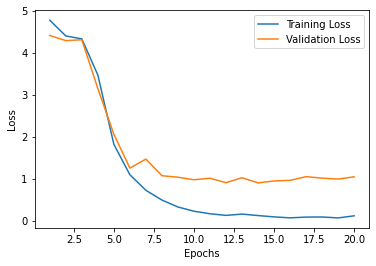

In [ ]:
#With Augmentation
a = [i for  i in range(1, 21)]
plt.plot(a, train_loss_list, label = 'Training Loss')
plt.plot(a, valid_loss_list, label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

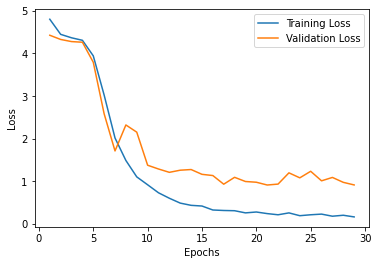

In [ ]:
#Without Augmentation
a = [i for  i in range(1, 30)]
plt.plot(a, train_loss_list, label = 'Training Loss')
plt.plot(a, valid_loss_list, label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
#Evaluation begins
i = 0
l1 = []
l2 = []

model.eval()
test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
for batch, (img, target) in enumerate(test_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    vcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    l1.append(pred.item())
    l2.append(target.item)

df = pd.DataFrame(columns=["Pred", "Target"])
df["Pred"] = l1
df["Target"] = l2
df.head()

,Pred,Target
0,60,60
1,22,22
2,40,40
3,3,9
4,47,18


In [ ]:
y = np.array(df["Target"])
y_pred = np.array(df["Pred"])

In [ ]:
print("Classification Report:")
print(classification_report(y, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.12      0.17         8
           1       0.38      0.50      0.43         6
           2       0.86      1.00      0.92         6
           3       0.92      0.86      0.89        14
           4       0.90      0.69      0.78        13
           5       1.00      0.75      0.86         8
           6       0.80      0.73      0.76        11
           7       1.00      0.64      0.78        11
           8       0.70      0.88      0.78         8
           9       0.83      0.56      0.67         9
          10       0.70      0.88      0.78         8
          11       0.50      0.67      0.57         6
          12       0.93      0.81      0.87        16
          13       0.82      0.75      0.78        12
          14       1.00      0.78      0.88         9
          15       1.00      1.00      1.00        10
          16       1.00      0.73      0.84        11
    

In [ ]:
print(list(y))
print(list(y_pred))

[50, 44, 49, 8, 36, 34, 16, 52, 9, 29, 0, 32, 56, 8, 29, 32, 45, 18, 39, 51, 47, 59, 19, 20, 52, 19, 36, 57, 1, 49, 3, 53, 12, 54, 54, 16, 14, 56, 28, 23, 39, 43, 22, 42, 19, 48, 61, 58, 2, 23, 52, 50, 48, 28, 22, 34, 56, 24, 26, 45, 19, 47, 17, 17, 12, 0, 39, 40, 16, 12, 25, 20, 55, 0, 8, 50, 38, 21, 49, 37, 44, 6, 55, 35, 3, 29, 35, 59, 26, 17, 55, 38, 55, 39, 17, 19, 40, 13, 1, 3, 21, 39, 25, 52, 12, 12, 36, 33, 4, 57, 15, 39, 53, 45, 14, 23, 13, 20, 14, 16, 61, 2, 50, 27, 45, 49, 3, 51, 35, 24, 32, 4, 59, 41, 54, 20, 18, 0, 35, 4, 4, 1, 12, 43, 23, 20, 40, 51, 43, 22, 56, 7, 13, 56, 25, 49, 6, 57, 28, 34, 36, 38, 48, 2, 55, 51, 61, 31, 56, 32, 12, 2, 30, 23, 21, 26, 29, 38, 29, 34, 4, 31, 4, 23, 31, 6, 9, 47, 42, 51, 40, 12, 50, 42, 15, 44, 41, 7, 15, 30, 51, 15, 27, 56, 6, 57, 49, 9, 38, 53, 39, 58, 19, 10, 50, 41, 7, 27, 60, 23, 45, 11, 25, 16, 49, 60, 7, 22, 39, 3, 53, 12, 5, 13, 13, 35, 31, 15, 28, 12, 37, 23, 58, 32, 49, 52, 30, 9, 21, 22, 32, 30, 27, 55, 60, 26, 14, 49, 4, 39

In [ ]:
(y == y_pred).sum()

469

In [ ]:
cm = ConfusionMatrix(actual_vector=y, predict_vector=y_pred)
print(cm)

Predict  0        1        2        3        4        5        6        7        8        9        10       11       12       13       14       15       16       17       18       19       20       21       22       23       24       25       26       27       28       29       30       31       32       33       34       35       36       37       38       39       40       41       42       43       44       45       46       47       48       49       50       51       52       53       54       55       56       57       58       59       60       61       
Actual
0        1        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        4        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0 

/usr/local/lib/python3.7/dist-packages/pycm/pycm_obj.py:195: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [ ]:
cm2 = ConfusionMatrix(actual_vector=y2, predict_vector=y_pred2)
print(cm2)

Predict  0        1        2        3        4        5        6        7        8        9        10       11       12       13       14       15       16       17       18       19       20       21       22       23       24       25       26       27       28       29       30       31       32       33       34       35       36       37       38       39       40       41       42       43       44       45       46       47       48       49       50       51       52       53       54       55       56       57       58       59       60       61       
Actual
0        4        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        3        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0        0 

/usr/local/lib/python3.7/dist-packages/pycm/pycm_obj.py:195: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)
